# Flux surface

In [1]:
R0 = 6.2 * u.m

<Quantity 6.2 m>

In [2]:
NSTX_PARAMS = dict(
    #     R0 = 0.8 * u.m,
    #     a0 = 0.64 * u.m,
    triangularity=0.3,
    elongation=1.7,
    aspect_ratio=0.3,
    A=-0.144,
)

{'triangularity': 0.3, 'elongation': 1.7, 'aspect_ratio': 0.3, 'A': -0.144}

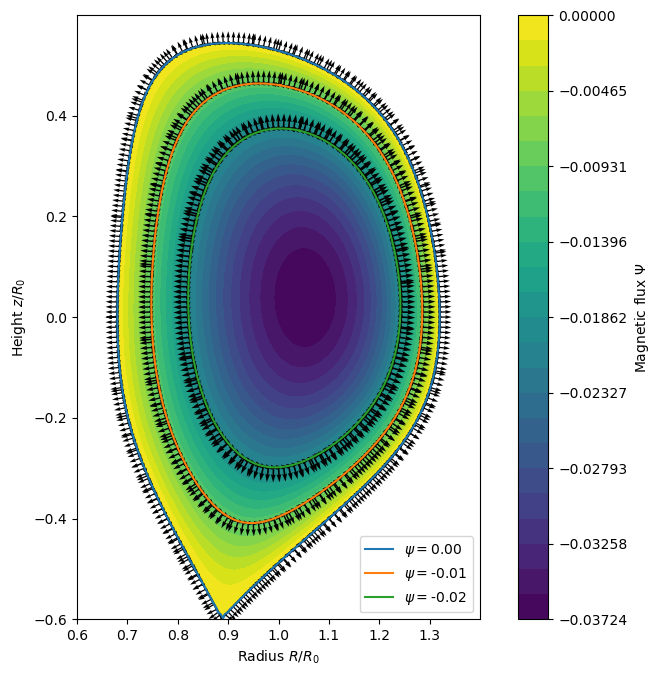

In [209]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
# params = NSTX_PARAMS
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot((0.6, 1.4, 0.001), (-0.6, 0.6, 0.001), vmax=-0)
for psi_value in [0, -0.01, -0.02]:
    fs = eq.get_flux_surface(psi_value)
    fs.plot(ax, B=True, n=True)

## On a grid

In [226]:
R, Z, psi = eq.get_grid_and_psi(
    rminmaxstep=(0.6, 1.4, 0.01), zminmaxstep=(-0.6, 0.6, 0.01)
)

ρ = psi / psi.min()
ρprime_r = np.gradient(ρ, R[0], axis=1)
ρprime_z = np.gradient(ρ, Z[:, 0], axis=0)
ρprime2 = ρprime_z ** 2 + ρprime_r ** 2
from scipy import interpolate

interpolator = interpolate.RectBivariateSpline(Z[:, 0], R[0], ρprime2)
interpolated_values = interpolator(fs.Z, fs.R, grid=False)

array([13.26109972, 13.01575153, 12.35878342, 11.71819271, 11.0969012 ,
       10.49832284,  9.9263164 ,  9.38514881,  8.87946938,  8.52250155,
        8.41376258,  7.992244  ,  7.62281135,  7.31188666,  7.30890015,
        7.06450578,  6.89865436,  6.89112339,  6.79976355,  6.78902096,
        6.80203344,  6.84548404,  6.9106124 ,  7.00758091,  7.14075741,
        7.24128469,  7.51006313,  7.52556002,  7.84398673,  8.04159804,
        8.18819926,  8.54917573,  8.75790601,  8.92132146,  9.29896869,
        9.68001787,  9.68385595, 10.05785871, 10.43262337, 10.80181485,
       10.84226426, 11.16114609, 11.51070493, 11.84914534, 12.17507135,
       12.22849488, 12.48588738, 12.78177845, 13.06214954, 13.32625702,
       13.57348372, 13.76440149, 13.80314712, 14.01424987, 14.20739087,
       14.38238045, 14.53912187, 14.67760726, 14.79791393, 14.90020103,
       14.98470634, 15.05174321, 15.08337864, 15.10156299, 15.13460653,
       15.15159993, 15.15312409, 15.13981881, 15.1123788 , 15.07

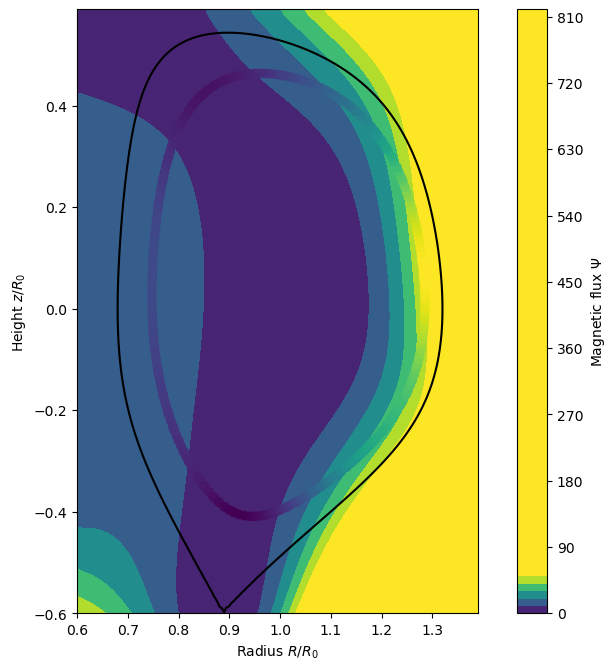

In [227]:
# levels = np.sort(np.linspace(PSI.min(), 0, num=25))
fig, ax = plt.subplots()
CS = ax.contourf(
    R, Z, ρprime2, levels=100, vmin=ρprime2[bools].min(), vmax=ρprime2[bools].max()
)
ax.scatter(fs.R, fs.Z, c=fs.GradRho2)
ax.contour(R, Z, psi, levels=[0], colors="black")  # display the separatrix

plt.colorbar(CS, label=r"Magnetic flux $\Psi$")
ax.set_xlabel("Radius $R/R_0$")
ax.set_ylabel("Height $z/R_0$")
ax.set_aspect("equal")

In [218]:
Ri, Zi = np.meshgrid(np.arange(R.shape[0]), np.arange(R.shape[1]))

In [219]:
from matplotlib import path

p = path.Path(np.vstack((fs.R, fs.Z)).T)
flags = p.contains_points(gridpoints)
bools = flags.reshape(R.shape)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [220]:
integrand = ((eq.A + (1 - eq.A) * R ** 2) / R) * bools

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
ϵ = 1 / params["aspect_ratio"]

3.125

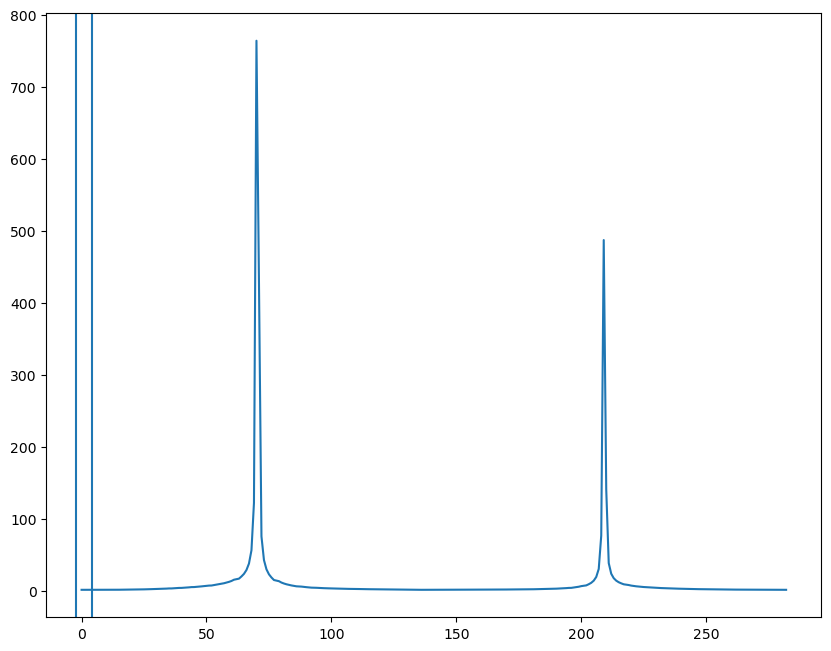

In [127]:
plt.plot(np.sqrt(1 + np.gradient(fs.Z, fs.R) ** 2))
plt.axvline(1 - ϵ)
plt.axvline(1 + ϵ)

In [118]:
trapezoid(trapezoid(integrand, R, axis=1), Z[:, 0])

0.3699475852544654

In [91]:
bools.shape

(120, 80)

In [97]:
import numba
import numpy as np

from numba import jit, njit


@jit(nopython=True)
def pointinpolygon(x, y, poly):
    n = len(poly)
    inside = False
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x, p1y = poly[0]
    for i in numba.prange(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside


@njit(parallel=True)
def parallelpointinpolygon(points, polygon):
    D = np.empty(len(points), dtype=numba.boolean)
    for i in numba.prange(0, len(D)):
        D[i] = pointinpolygon(points[i, 0], points[i, 1], polygon)
    return D

In [87]:
R[Ri.ravel()[flags], Zi.ravel()[flags]]

array([0.73, 0.73, 0.73, ..., 1.3 , 1.3 , 1.31])

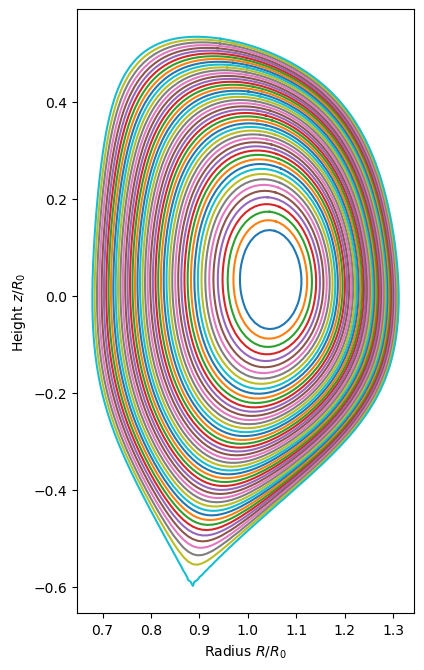

In [25]:
levels = np.linspace(-0.03556, 0, 50)
surfaces = list(eq.get_multiple_flux_surfaces(levels))

# ax = eq.plot()
gradPhi = []
rightmost = []
ax = None
for fs in surfaces:
    ax = fs.plot(ax, legend=False)
    gradPhi.append(trapezoid(fs.Bphivals, fs.lp))
    rightmost.append(fs.R.max())

In [28]:
trapezoid(gradPhi, rightmost)

1.7131836078021707

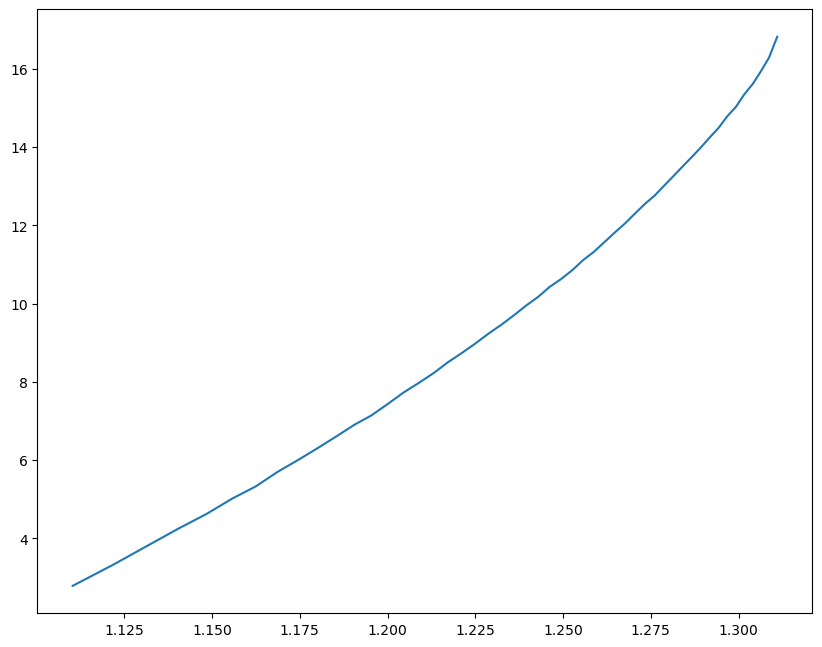

In [27]:
plt.plot(rightmost, gradPhi)

In [ ]:
plt.plot(fs.theta)

In [ ]:
def dot_products():
    for fs in surfaces:
        dthetadR = np.gradient(fs.theta, fs.R)
        dthetadZ = np.gradient(fs.theta, fs.Z)
        dot_product = fs.Brvals * dthetadR + fs.Bzvals * dthetadZ
        yield fs.flux_surface_average(dot_product)


plt.plot(levels, list(dot_products()))

## One particular surface

In [ ]:
ax = eq.plot()
fs = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

In [ ]:
fs.trapped_fraction()